Gradient Descent: Multi-Layer Perceptron Example
======

Suppose we have 2-dimensional data, where there are two classes; and each class is divided into two clusters. All four clusters have Gaussian distributions.

This data is known as eXclusive OR (XOR) data; i.e. the data belongs to the positive class iff (if and only if) one input is positive and the other input is negative.

Positive Class:

Mean(Quadrant2) = [ −1, 1 ]   
Mean(Quadrant4) = [ 1, −1 ]  

Negative Class:
Mean(Quadrant1) = [ 1, 1 ]  
Mean(Quadrant3) = [ −1, −1 ]  
Covariance(Quadrant1) = Covariance(Quadrant2) = Covariance(Quadrant3) = Covariance(Quadrant4) = [ [ 0.1, 0.0 ], [ 0.0, 0.1 ] ]

---
Create the Data
------

In [1]:
import numpy as np

count = 1000
proportion_quadrant = 0.25

X_q1 = np.random.multivariate_normal(mean = [   1,   1 ],
                                     cov = [ [ 0.1, 0.0 ], [ 0.0, 0.1 ] ],
                                     size = int(proportion_quadrant * count))
X_q2 = np.random.multivariate_normal(mean = [  -1,   1 ],
                                     cov = [ [ 0.1, 0.0 ], [ 0.0, 0.1 ] ],
                                     size = int(proportion_quadrant * count))
X_q3 = np.random.multivariate_normal(mean = [  -1,  -1 ],
                                     cov = [ [ 0.1, 0.0 ], [ 0.0, 0.1 ] ],
                                     size = int(proportion_quadrant * count))
X_q4 = np.random.multivariate_normal(mean = [   1,  -1 ],
                                     cov = [ [ 0.1, 0.0 ], [ 0.0, 0.1 ] ],
                                     size = int(proportion_quadrant * count))

X = np.concatenate((X_q2, X_q4, X_q1, X_q3), axis = 0).astype("float32")
Y = np.array([1]*int(2 * proportion_quadrant * count) + [0]*int(2 * proportion_quadrant * count)).astype("float32")
index = np.arange(count)
np.random.shuffle(index)

trnCount = int(0.8 * count)
valCount = int(0.1 * count)
tstCount = int(0.1 * count)

trnX = X[index[:trnCount]]
trnY = Y[index[:trnCount]]
valX = X[index[trnCount:(trnCount+valCount)]]
valY = Y[index[trnCount:(trnCount+valCount)]]
tstX = X[index[(trnCount+valCount):(trnCount+valCount+tstCount)]]
tstY = Y[index[(trnCount+valCount):(trnCount+valCount+tstCount)]]

print("trn shapes:", trnX.shape, trnY.shape, sep = "\t")
print("val shapes:", valX.shape, valY.shape, sep = "\t")
print("tst shapes:", tstX.shape, tstY.shape, sep = "\t")

trn shapes:	(800, 2)	(800,)
val shapes:	(100, 2)	(100,)
tst shapes:	(100, 2)	(100,)


---
Plot the Data
------

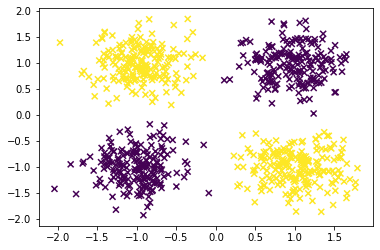

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(trnX[:,0], trnX[:,1], c = trnY, marker = 'x')
plt.show()

---
Create the Model
------

In [3]:
import tensorflow
from tensorflow.keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(2, activation = "relu", input_shape=(2,)))
model.add(layers.Dense(1, activation = "sigmoid"))
model.summary()
model.compile(loss = "binary_crossentropy", optimizer = optimizers.SGD(), metrics = [ "accuracy" ])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 6         
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


---
Predict for a Batch of Examples (forward propagation)
------

In [4]:
old_weights = model.get_weights()
indices = slice(0, 10)
batch_size = indices.stop - indices.start
print(model.predict(trnX[indices]))

np0 = np.float32(0)
np1 = np.float32(1)
def sigmoid(x):
    return np1 / (np1 + np.exp(-x))

activations1 = np.maximum(np0, np.dot(trnX[indices], old_weights[0]) + old_weights[1])
activations2 = sigmoid(np.dot(activations1, old_weights[2]) + old_weights[3])
print(activations2)

1/1 [==============================] - 1s 752ms/step
[[0.3784595 ]
 [0.5       ]
 [0.68409914]
 [0.5       ]
 [0.6149621 ]
 [0.7338776 ]
 [0.6108557 ]
 [0.3922186 ]
 [0.40918547]
 [0.5       ]]
[[0.3784595 ]
 [0.5       ]
 [0.68409914]
 [0.5       ]
 [0.6149621 ]
 [0.7338776 ]
 [0.61085576]
 [0.3922186 ]
 [0.4091855 ]
 [0.5       ]]


---
Train on a Batch of Examples
------

In [5]:
old_weights = model.get_weights()
model.fit(trnX[indices], trnY[indices], epochs = 1, batch_size = batch_size)
new_weights = model.get_weights()
print(new_weights[0] - old_weights[0])
print(new_weights[1] - old_weights[1])
print(new_weights[2] - old_weights[2])
print(new_weights[3] - old_weights[3])

1/1 [==============================] - 0s 156ms/step - loss: 0.8336 - accuracy: 0.4000
[[-7.5459480e-05  1.1222959e-03]
 [-1.0863543e-03  3.6120415e-04]]
[-1.3914831e-04 -3.8309394e-05]
[[ 0.00154653]
 [-0.00162321]]
[0.00067634]


In [6]:
np0 = np.float32(0)
np1 = np.float32(1)
lr = model.optimizer.lr.numpy()    # learning rate
predictions = activations2

w1_update = - lr * np.dot(np.transpose(trnX[indices]), 
                          ((activations1 > np0) * np1) *
                              np.dot(
                                  (predictions - trnY[indices].reshape(batch_size, 1)) \
                                      / (predictions * (np1 - predictions)) \
                                      * (predictions * (np1 - predictions)),
                                  np.transpose(old_weights[2])
                              )
                         ) / batch_size

b1_update = - lr * np.dot(np.transpose(np.ones((batch_size, 1), dtype = "float32")),
                          ((activations1 > np0) * np1) *
                              np.dot(
                                  (predictions - trnY[indices].reshape(batch_size, 1)) \
                                      / (predictions * (np1 - predictions)) \
                                      * (predictions * (np1 - predictions)),
                                  np.transpose(old_weights[2])
                              )
                         ) / batch_size
            
print(w1_update)
print(b1_update)

w2_update = - lr * np.dot(np.transpose(activations1),
                          (predictions - trnY[indices].reshape(batch_size, 1)) \
                              / (predictions * (np1 - predictions)) \
                              * (predictions * (np1 - predictions))) / batch_size

b2_update = - lr * np.dot(np.transpose(np.ones((batch_size, 1), dtype = "float32")),
                          (predictions - trnY[indices].reshape(batch_size, 1)) \
                              / (predictions * (np1 - predictions)) \
                              * (predictions * (np1 - predictions))) / batch_size

print(w2_update)
print(b2_update)

[[-7.5496311e-05  1.1223138e-03]
 [-1.0863653e-03  3.6122685e-04]]
[[-1.3914832e-04 -3.8309365e-05]]
[[ 0.00154653]
 [-0.00162323]]
[[0.00067634]]


In [7]:
tensorflow.random.set_seed(1)
model = models.Sequential()
model.add(layers.Dense(2, activation = "relu", input_shape=(2,)))
model.add(layers.Dense(1, activation = "sigmoid"))
model.compile(loss = "binary_crossentropy", optimizer = optimizers.SGD(), metrics = [ "accuracy" ])
print(model.get_weights())
model.fit(trnX, trnY, validation_data = (valX, valY), epochs = 10, batch_size = 1)
weights = model.get_weights()
model.evaluate(tstX, tstY)
print(weights)


[array([[-0.82025856,  0.9834243 ],
       [ 0.32081985, -0.16032863]], dtype=float32), array([0., 0.], dtype=float32), array([[ 0.02858698],
       [-0.15971637]], dtype=float32), array([0.], dtype=float32)]
Epoch 1/10
800/800 [==============================] - 1s 1ms/step - loss: 0.6610 - accuracy: 0.5850 - val_loss: 0.6073 - val_accuracy: 0.7100
Epoch 2/10
800/800 [==============================] - 1s 1ms/step - loss: 0.5088 - accuracy: 0.8687 - val_loss: 0.3886 - val_accuracy: 0.9700
Epoch 3/10
800/800 [==============================] - 1s 1ms/step - loss: 0.3205 - accuracy: 0.9712 - val_loss: 0.2484 - val_accuracy: 0.9900
Epoch 4/10
800/800 [==============================] - 1s 1ms/step - loss: 0.2176 - accuracy: 0.9812 - val_loss: 0.1788 - val_accuracy: 0.9900
Epoch 5/10
800/800 [==============================] - 1s 1ms/step - loss: 0.1634 - accuracy: 0.9850 - val_loss: 0.1368 - val_accuracy: 0.9900
Epoch 6/10
800/800 [==============================] - 1s 1ms/step - loss: 0.1317 

---
New Features Generated by the First Dense Layer
------

25/25 [==============================] - 0s 539us/step


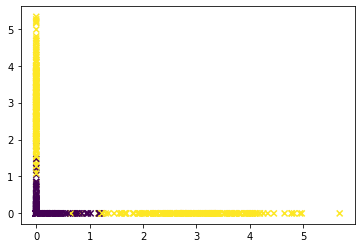

In [8]:
# Which scores belong to quadrant 2; i.e. same direction as first neuron, opposite direction of second neuron?
# Which scores belong to quadrant 4; i.e. same direction as second neuron, opposite direction of first neuron?
activations = models.Model(model.input, model.layers[0].output)
features = activations.predict(trnX)
plt.scatter(features[:,0], features[:,1], c = trnY, marker = 'x')
plt.show()